<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/kurs-analiza-danych-2022/blob/create-spark-materials/Tydzie%C5%84%206/Preprocessing%20w%20Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Sparka

## Utworzenie środowiska pyspark do obliczeń

Tworzymy swoje środowisko z pysparkiem we wenętrzu naszych zasobów chmurowych

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q ftp.ps.pl/pub/apache/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [3]:
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [5]:
!pip install -q findspark

import findspark
findspark.init()

## Utworzenie sesji z pyspark


Utworzymy testowo sesję aby zobaczyć czy działa. Element ten jest wspólny również gdy systemy sparkowe pracują w sposób ciągły, a nie są tworzone przez naszą sesję.

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

## Podłączenie Google Drive do sesji colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing i narzędziownik Apache Spark

## Wczytanie danych do Sparka

W tej części wczytamy sobie nasz plik `flights.csv` do przetwarzania w Spark.

Z uwagi na to, że nasz plik to csv bez nagłówka - trzeba zdefiniować schemat dla danych, które przetwarzamy

Przypomnijmy listę pól
YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,\
DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,\
TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,\
TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,\
CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,\
LATE_AIRCRAFT_DELAY,WEATHER_DELAY

_Sporo ich. Więc najpierw trochę magii (bo nie chce mi się kodować każdego pola ręcznie, a jestem leniwy). Ufam, że przykład pozwoli rozszerzyć zastosowanie do bardziej skomplikowanych zastosowań. Na pocieszenie dodam, że wczytywanie csv bez nagłówka to najgorszy scenariusz w wersji wczytywania w sparku._

In [27]:
pola_zbiorczo = '''YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY'''
pola = pola_zbiorczo.split(',')

In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)


In [29]:
from pyspark.sql.types import StructType, StringType, IntegerType, BooleanType, FloatType, TimestampType, DateType, ArrayType, MapType
from typing import List, Tuple, Dict, Any
map_python_types_2_spark_types = {
    str : StringType(),
    int : IntegerType(),
    bool : BooleanType(),
    float: FloatType(),
    'timestamp' : TimestampType(),
    'date' : DateType(),
    List[str] : ArrayType(StringType()),
    Tuple[str] : ArrayType(StringType()),
    Dict[str, str] : MapType(StringType(), StringType())
}

column_type_collection = {
    int : ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'DEPARTURE_DELAY', 'TAXI_OUT', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'TAXI_IN', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED' ],
    str : ['AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'WHEELS_OFF', 'WHEELS_ON', 
      'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'
    ]
}

map_column_names_2_types = {}

for pole in pola:
  for python_type, column_list in column_type_collection.items():
    if pole in column_list:
      map_column_names_2_types[pole] = map_python_types_2_spark_types[python_type]

print(map_column_names_2_types)



{'YEAR': IntegerType, 'MONTH': IntegerType, 'DAY': IntegerType, 'DAY_OF_WEEK': IntegerType, 'AIRLINE': StringType, 'FLIGHT_NUMBER': StringType, 'TAIL_NUMBER': StringType, 'ORIGIN_AIRPORT': StringType, 'DESTINATION_AIRPORT': StringType, 'SCHEDULED_DEPARTURE': StringType, 'DEPARTURE_TIME': StringType, 'DEPARTURE_DELAY': IntegerType, 'TAXI_OUT': IntegerType, 'WHEELS_OFF': StringType, 'SCHEDULED_TIME': IntegerType, 'ELAPSED_TIME': IntegerType, 'AIR_TIME': IntegerType, 'DISTANCE': IntegerType, 'WHEELS_ON': StringType, 'TAXI_IN': IntegerType, 'SCHEDULED_ARRIVAL': StringType, 'ARRIVAL_TIME': StringType, 'ARRIVAL_DELAY': IntegerType, 'DIVERTED': IntegerType, 'CANCELLED': IntegerType, 'CANCELLATION_REASON': StringType, 'AIR_SYSTEM_DELAY': StringType, 'SECURITY_DELAY': StringType, 'AIRLINE_DELAY': StringType, 'LATE_AIRCRAFT_DELAY': StringType, 'WEATHER_DELAY': StringType}


In [30]:
schemat = StructType()
for pole, typ in map_column_names_2_types.items():
    schemat = schemat.add(pole, typ, True)


In [31]:
flights = spark.read.format('csv').option("header", False).schema(schemat).load('/content/drive/MyDrive/flights.csv')
flights.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [32]:
flights.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: string (nullable = true)
 |-- DEPARTURE_TIME: string (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: string (nullable = true)
 |-- ARRIVAL_TIME: string (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = 

Wykonajmy jeszcze proste statystyki ze zbioru by zobaczyć poprawność jego wczytania

In [33]:
%%time
flights.count()

CPU times: user 27.5 ms, sys: 880 µs, total: 28.4 ms
Wall time: 3.86 s


5819079

In [34]:
%%time
for pole in ['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DIVERTED', 'CANCELLED']:
  print(f'Pole {pole}\n')
  print(flights.select(pole).distinct().sort(pole).toPandas())

Pole YEAR

   YEAR
0  2015
Pole MONTH

    MONTH
0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10     11
11     12
Pole DAY

    DAY
0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
10   11
11   12
12   13
13   14
14   15
15   16
16   17
17   18
18   19
19   20
20   21
21   22
22   23
23   24
24   25
25   26
26   27
27   28
28   29
29   30
30   31
Pole AIRLINE

   AIRLINE
0       AA
1       AS
2       B6
3       DL
4       EV
5       F9
6       HA
7       MQ
8       NK
9       OO
10      UA
11      US
12      VX
13      WN
Pole TAIL_NUMBER

     TAIL_NUMBER
0           None
1          7819A
2          7820L
3         D942DN
4         N001AA
...          ...
4893      N997DL
4894      N998AT
4895      N998DL
4896      N999DN
4897      N9EAMQ

[4898 rows x 1 columns]
Pole ORIGIN_AIRPORT

    ORIGIN_AIRPORT
0            10135
1            10136
2            10140
3            10141
4            10146
..  

In [35]:
flights.createOrReplaceTempView("flights")

## Usuwanie duplikatów

Jeśli w naszym zbiorze znajdują się identyczne rekordy - to jest to prawdopodobnie pomyłka, którą należy poprawić

In [36]:
flights.count()

5819079

In [37]:
flights.distinct().count()

5819079

Wtedy odpowiednim poleceniem byłoby 

In [38]:
flights = flights.dropDuplicates()

## Missing values

Kolejnym problemem w danych, który możemy rozwiązywać w pyspark są wartości None w danych. Najpierw wygenerujemy podsumowanie

In [39]:
from pyspark.sql.functions import col, isnan, when, count

flights.select( [
  count(when(isnan(c) | col(c).isNull(), c)).alias(c)
  for c 
  in flights.columns
]).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,5729195,4755640,4755640,4755640,4755640,4755640


Wtedy zwyczajowo mamy dylemat rozwiązywany przez jedną z operacji

* odrzucenie kolumny
* odrzucenie rekordów
* uzupełnienie danych

odrzucenie kolumny jest na tę chwilę już dobrze znaną operacją. Można wykonać select kolumn, które pozostają w analizie lub też dokonać jawnego drop


In [40]:
flights = flights.drop('CANCELLATION_REASON')

flights.limit(5).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,2,1,7,UA,1175,None,ORD,PDX,1706,None,NaN,NaN,None,277,NaN,NaN,1739,None,NaN,1943,None,NaN,0,1,None,None,None,None,None
1,2015,3,1,7,UA,1618,None,TPA,EWR,1942,None,NaN,NaN,None,168,NaN,NaN,997,None,NaN,2230,None,NaN,0,1,None,None,None,None,None
2,2015,2,1,7,AA,192,N3JUAA,LAX,BOS,2150,None,NaN,NaN,None,323,NaN,NaN,2611,None,NaN,0613,None,NaN,0,1,None,None,None,None,None
3,2015,2,1,7,WN,2009,N928WN,MCI,MDW,2005,None,NaN,NaN,None,85,NaN,NaN,405,None,NaN,2130,None,NaN,0,1,None,None,None,None,None
4,2015,2,1,7,WN,2248,N7709A,DEN,MKE,1020,None,NaN,NaN,None,135,NaN,NaN,896,None,NaN,1335,None,NaN,0,1,None,None,None,None,None


Możemy jednak chcieć odrzucić wiersze

In [41]:
flights = flights.dropna(thresh = 6)

flights.select( [
  count(when(isnan(c) | col(c).isNull(), c)).alias(c)
  for c 
  in flights.columns
]).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,0,0,0,0,14721,0,0,0,86153,86153,89047,89047,6,105071,105071,0,92513,92513,0,92513,105071,0,0,4755640,4755640,4755640,4755640,4755640


Do uzupełnienia wartości służy natomiast metoda .fillna przyjmują albo pojedynczą wartość lub słownik takich wartości per kolumna

In [42]:
filler_map = { 'TAIL_NUMBER' : 'Missing', 'DEPARTURE_TIME' : 'Missing', 'DEPARTURE_DELAY' : 0 , 'TAXI_OUT' : 0,
              'WHEELS_OFF' : 'Missing', 'SCHEDULED_TIME' : 0, 'ELAPSED_TIME' : 0, 'AIR_TIME' : 0, 
              'WHEELS_ON' : 'Missing',  'TAXI_IN' : 0, 'ARRIVAL_TIME' : 'Missing',  'ARRIVAL_DELAY' : 0 }
flights = flights.fillna(filler_map)

flights.select( [
  count(when(isnan(c) | col(c).isNull(), c)).alias(c)
  for c 
  in flights.columns
]).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4755640,4755640,4755640,4755640,4755640


In [43]:
flights = flights.fillna('')
flights.select( [
  count(when(isnan(c) | col(c).isNull(), c)).alias(c)
  for c 
  in flights.columns
]).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
flights.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = false)
 |-- FLIGHT_NUMBER: string (nullable = false)
 |-- TAIL_NUMBER: string (nullable = false)
 |-- ORIGIN_AIRPORT: string (nullable = false)
 |-- DESTINATION_AIRPORT: string (nullable = false)
 |-- SCHEDULED_DEPARTURE: string (nullable = false)
 |-- DEPARTURE_TIME: string (nullable = false)
 |-- DEPARTURE_DELAY: integer (nullable = false)
 |-- TAXI_OUT: integer (nullable = false)
 |-- WHEELS_OFF: string (nullable = false)
 |-- SCHEDULED_TIME: integer (nullable = false)
 |-- ELAPSED_TIME: integer (nullable = false)
 |-- AIR_TIME: integer (nullable = false)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: string (nullable = false)
 |-- TAXI_IN: integer (nullable = false)
 |-- SCHEDULED_ARRIVAL: string (nullable = false)
 |-- ARRIVAL_TIME: string (nullable = false)
 |-- ARRIVAL_DELAY: int

## Outlier

Outliery usuwamy za pomocą odpowiednich filter lub where. Nie ma więc sensu szerzej opisywać tego zjawiska

## Wizualizacja danych ze Spark

Spark nie posiada wbudowanych narzędzi do tworzenia wykresów. Podstawowo zastosowanie znajdują tu zatem narzędzie z matplotlib

In [45]:
from matplotlib import pyplot as plt 

Kluczem jest oczywiście transformacja pozwalająca na zrzucenie danych do 

<BarContainer object of 200 artists>

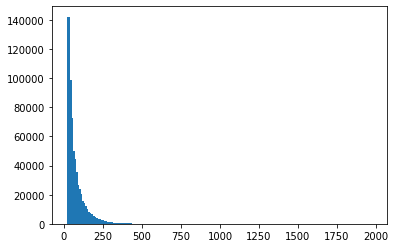

In [59]:
hist = flights.where('ARRIVAL_DELAY > 30').select('ARRIVAL_DELAY').rdd.flatMap(lambda row: row).histogram(200)
data = {
    'bins' : hist[0][:-1],
    'freq' : hist[1]
}
plt.bar(data['bins'], data['freq'], width = 20)

<BarContainer object of 200 artists>

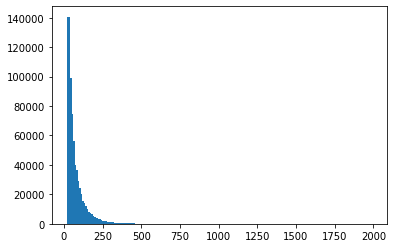

In [60]:
hist = flights.where('DEPARTURE_DELAY > 30').select('DEPARTURE_DELAY').rdd.flatMap(lambda row: row).histogram(200)
data = {
    'bins' : hist[0][:-1],
    'freq' : hist[1]
}
plt.bar(data['bins'], data['freq'], width=20)